# <img style="float: left; padding-right: 10px; width: 45px" src="fig/iacs.png"> S-109A Introduction to Data Science 
## Homework 3 - Forecasting Bike Sharing Usage



**Harvard University**<br/>
**Summer 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

Names of people you have worked with goes here: 

<hr style="height:2pt">

In [1]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()

![bike_sharing](fig/BSS.png)

<div class="theme">  Main Theme: Multiple Linear Regression, Subset Selection, Polynomial Regression </div>
### Overview 

You are hired by the administrators of the [Capital Bikeshare program](https://www.capitalbikeshare.com) program in Washington D.C., to **help them predict the hourly demand for rental bikes** and **give them suggestions on how to increase their revenue**. You will prepare a small report for them.

The hourly demand information would be useful in planning the number of bikes that need to be available in the system on any given hour of the day, and also in monitoring traffic in the city. It costs the program money if bike stations are full and bikes cannot be returned, or empty and there are no bikes available. You will use multiple linear regression and polynomial regression and will explore techniques for subset selection. The goal is to build a regression model that can predict the total number of bike rentals in a given hour of the day, based on attributes about the hour and the day. 

An example of a suggestion to increase revenue might be to offer discounts during certain times of the day either during holidays or non-holidays. Your suggestions will depend on your observations of the seasonality of ridership.

The data for this problem were collected from the Capital Bikeshare program over the course of two years (2011 and 2012).


### Use only the libraries below:

In [9]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from pandas.plotting import scatter_matrix

import seaborn as sns


%matplotlib inline

## Data Exploration & Preprocessing, Multiple Linear Regression, Subset Selection


### Overview
The initial data set is provided in the file `data/BSS_hour_raw.csv`. You will add some features that will help us with the analysis and then separate it into training and test sets. Each row in this file contains 12 attributes and each entry represents one hour of a 24-hour day with its weather, etc, and the number of rental rides for that day divided in categories according to if they were made by registered or casual riders. Those attributes are the following:

- `dteday` (date in the format YYYY-MM-DD, e.g. 2011-01-01)
- `season` (1 = winter, 2 = spring, 3 = summer, 4 = fall)
- `hour` (0 for 12 midnight, 1 for 1:00am, 23 for 11:00pm)
- `weekday` (0 through 6, with 0 denoting Sunday)
- `holiday` (1 = the day is a holiday, 0 = otherwise)
- `weather`
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm
    - 4: Heavy Rain + Thunderstorm + Mist, Snow + Fog 
- `temp` (temperature in Celsius)
- `atemp` (apparent temperature, or relative outdoor temperature, in Celsius)
- `hum` (relative humidity)
- `windspeed` (wind speed)
- `casual` (number of rides that day made by casual riders, not registered in the system)
- `registered` (number of rides that day made by registered riders)

### General Hints
- Use pandas .describe() to see statistics for the dataset.
- When performing manipulations on column data it is useful and often more efficient to write a function and apply this function to the column as a whole without the need for iterating through the elements.
- A scatterplot matrix or correlation matrix are both good ways to see dependencies between multiple variables.
- For Question 2, a very useful pandas method is .groupby(). Make sure you aggregate the rest of the columns in a meaningful way. Print the dataframe to make sure all variables/columns are there!

### Resources 
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html

<div class="exercise"> <b> Question 1: Explore how Bike Ridership varies with Hour of the Day </b> </div>

#### Learn your Domain and Perform a bit of Feature Engineering

**1.1** Load the dataset from the csv file `data/BSS_hour_raw.csv` into a pandas dataframe that you name `bikes_df`. Do any of the variables' ranges or averages seem suspect? Do the data types make sense?

**1.2** Notice that the variable in column `dteday` is a pandas `object`, which is **not**  useful when you want to extract the elements of the date such as the year, month, and day. Convert `dteday` into a `datetime` object to prepare it for later analysis.

**1.3** Create three new columns in the dataframe:
- `year` with 0 for 2011 and 1 for 2012.
- `month` with 1 through 12, with 1 denoting Jan. 
- `counts` with the total number of bike rentals for that day (this is the response variable for later).

**1.4** Use visualization to inspect and comment on how **casual** rentals and **registered** rentals vary with the `hour`. 

**1.5** Use the variable `holiday` to show how **holidays** affect the relationship in question 1.4.  What do you observe? 

**1.6** Use visualization to show how **weather** affects **casual** and **registered** rentals. What do you observe? 

### Answers

#### 1.1 Load the dataset from the csv file  ...

In [10]:
# your code here

bikes_df = pd.read_csv('data/BSS_hour_raw.csv')
print(bikes_df.dtypes)

bikes_df.describe()


dteday         object
season          int64
hour            int64
holiday         int64
weekday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
dtype: object


,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,1.106918,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,3.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,3.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,4.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


<HR>
Your answer here
<HR>

Season, holiday, like this kinds of data is not useful when you use describe method.

It does not have any meaning with 2.5 , 0.02; demical number. 

They are originally not numeric varibles, so we have to care about dealing with those.

and dteday is object!

#### 1.2 Notice that the variable in column ....

In [11]:
# your code here
bikes_df['dteday'] = pd.to_datetime(bikes_df['dteday'])


#### 1.3 Create three new columns ...

In [12]:
# your code here

#bikes_df['year'],bikes_df['month'] = bikes_df.dteday.split('-')
bikes_df['month'] = bikes_df['dteday'].dt.month
bikes_df['year'] = bikes_df['dteday'].dt.year.apply({2011:0, 2012:1}.get)
bikes_df['counts'] = bikes_df['casual'] + bikes_df['registered']
bikes_df.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,month,year,counts
0,2011-01-01,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,1,0,16
1,2011-01-01,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,1,0,40
2,2011-01-01,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,1,0,32
3,2011-01-01,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,1,0,13
4,2011-01-01,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,0,1


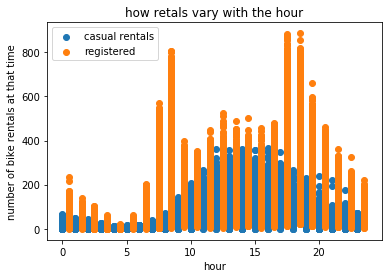

In [13]:
# your code here
#use scatter plot to visualization.
#one dot = each day's specific time
plt.scatter(bikes_df['hour'],bikes_df['casual'], alpha =1 , label="casual rentals")
plt.scatter(bikes_df['hour']+0.5,bikes_df['registered'],alpha =1)
plt.xlabel("hour")
plt.ylabel("number of bike rentals at that time")
plt.title("how retals vary with the hour")
plt.legend()
#0.5 to compare distinctly

<HR>
Your answer here<HR>

We can see that it is very rare to rent bike in the midnight.
Also rush hour is the busiest time of the day.

#### 1.5 Use the variable holiday to show how holidays affect the relationship in question 1.4. What do you observe?

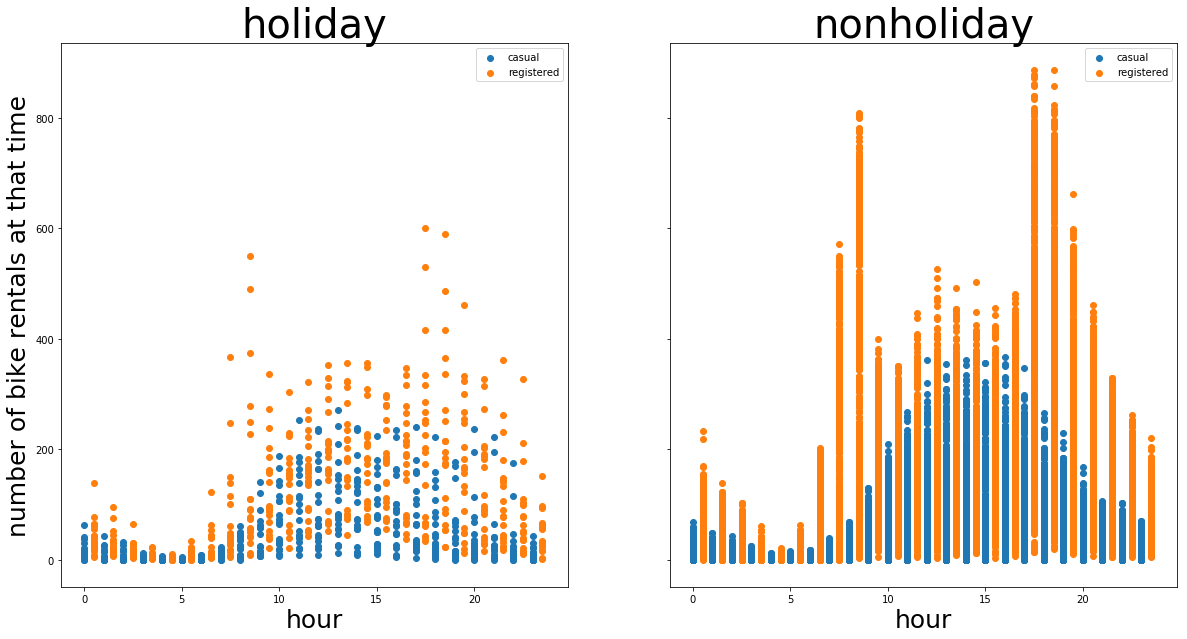

In [14]:
# your code here
#one dot = each day's specific time
fig, ax = plt.subplots(1,2, figsize=(20,10), sharey=True) #make 2 plot to compare
holiday = bikes_df['holiday'] == 1 #condition holiday
ax[0].scatter(bikes_df[holiday]['hour'],bikes_df[holiday]['casual'])
ax[0].scatter(bikes_df[holiday]['hour']+0.5,bikes_df[holiday]['registered'],alpha =1)
ax[0].set_title("holiday", fontsize =40)
ax[0].set_ylabel("number of bike rentals at that time", fontsize=25)
ax[0].set_xlabel("hour", fontsize=25)
ax[0].legend()

nonholiday =  bikes_df['holiday'] == 0
ax[1].scatter(bikes_df[nonholiday]['hour'],bikes_df[nonholiday]['casual'])
ax[1].scatter(bikes_df[nonholiday]['hour']+0.5,bikes_df[nonholiday]['registered'],alpha =1)
ax[1].set_title("nonholiday", fontsize =40)
ax[1].set_xlabel("hour", fontsize=25)
ax[1].legend()


<HR>
Your answer here<BR>
<HR>

We can see the distribution is pretty much same but average is smaller.
Especially commuting time (about 8am , 19pm) is significantly smaller than usual day.

#### 1.6  Use visualization to show how weather affects casual and registered rentals. What do you observe?

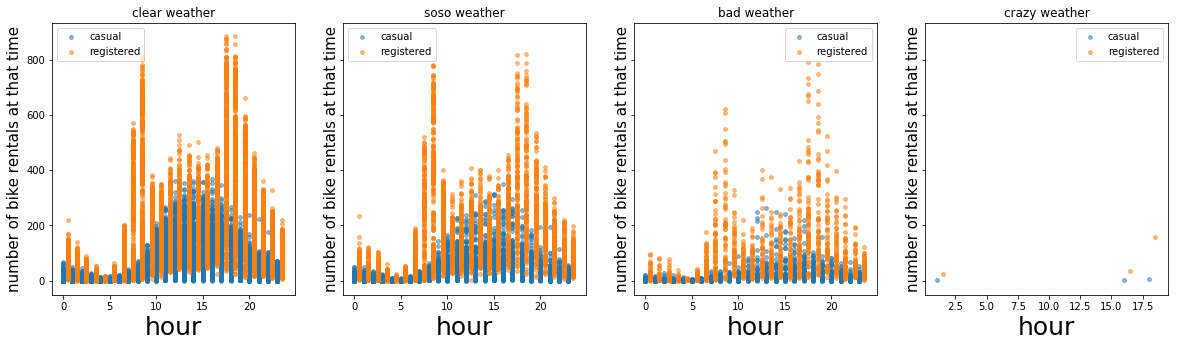

In [16]:
# your code here

#one dot = each day's specific time
fig, ax = plt.subplots(1,4, figsize=(20,5), sharey=True) #make 2 plot to compare
#weather definition
weather_name = ["clear","soso","bad", "crazy"]
for i in range(4):
    weather = bikes_df['weather'] == i+1 #condition weather
    ax[i].scatter(bikes_df[weather]['hour'],bikes_df[weather]['casual'], s=15, alpha=0.5)
    ax[i].scatter(bikes_df[weather]['hour']+0.5,bikes_df[weather]['registered'],alpha =0.5, s=15)
    ax[i].set_title("{0} weather".format(weather_name[i], fontsize =40))
    ax[i].set_ylabel("number of bike rentals at that time", fontsize=15)
    ax[i].set_xlabel("hour", fontsize=25)
    ax[i].legend()


<HR>
Your answer here
<HR>
Of course, as weather is worse, less people want to go out.
So in crazy weather, which is heavy rain and snow, almost nobody in outside.

<div class='exercise'> <b> Question 2: Explore Seasonality on Bike Ridership. </b></div>
#### Seasonality and weather

Now let's examine the effect of weather and time of the year. For example, you want to see how ridership varies with season of the year. 

**2.1** Make a new dataframe with the following subset of attributes from the previous dataset and with each entry being **ONE** day:

- `dteday`, the timestamp for that day (fine to set to noon or any other time)
- `weekday`, the day of the week
- `weather`, the most severe weather that day
- `season`, the season that day falls in
- `temp`, the average temperature
- `atemp`, the average atemp that day
- `windspeed`, the average windspeed that day
- `hum`, the average humidity that day
- `casual`, the **total** number of rentals by casual users
- `registered`, the **total** number of rentals by registered users
- `counts`, the **total** number of rentals

Name this dataframe `bikes_by_day` and use it for all of Question 2.

**2.2** How does **season** affect the number of bike rentals for **casual riders** or **registered riders** per day? Use the variable `season` for this question. Comment on your observations. 

**2.3** What percentage of rentals are made by casual riders or registered riders for each day of the week? Comment on any patterns you see and give a possible explanation.

**2.4** How is the **distribution of total number of bike rentals** different for sunny days vs cloudy days?

**2.5** Visualize how the **total number of rides** per day varies with the **season**. Do you see any **outliers**? (We define an outlier as a value 1.5 times the IQR above the 75th percentile or 1.5 times the IQR below the 25th percentiles. This is the same rule used by pyplot's boxplot function). If you see any outliers, identify those dates and investigate if they are a chance occurence, an error in the data collection, or an important event.

#### HINT
- Use .copy() when creating the new dataframe, so you leave the original untouched. We will come back to it later.
- Use .groupby() to creat the new dataframe. You will have to make some choice on how to aggregate the variables.

### Answers

#### 2.1 Make a new dataframe with the following subset ...

In [17]:
# your code here
# make df with day group first
bikes_by_day = bikes_df.groupby([pd.Grouper(key='dteday')]).sum()
#split it in the day_df

#we already make timestamp by to_datetime, so do not need to do again.
bikes_by_day['dteday'] = bikes_by_day.index
bikes_by_day['weekday'] = bikes_by_day['dteday'].dt.dayofweek
bikes_by_day['weather']= bikes_df.groupby([pd.Grouper(key='dteday')]).weather.max()
#it does not matter weather max or min to find season
bikes_by_day['season'] = bikes_df.groupby([pd.Grouper(key='dteday')]).season.max()
bikes_by_day['temp'] = bikes_df.groupby([pd.Grouper(key='dteday')]).temp.mean()
bikes_by_day['atemp'] = bikes_df.groupby([pd.Grouper(key='dteday')]).atemp.mean()
bikes_by_day['windspeed'] = bikes_df.groupby([pd.Grouper(key='dteday')]).windspeed.mean()
bikes_by_day['hum'] = bikes_df.groupby([pd.Grouper(key='dteday')]).hum.mean()
bikes_by_day = bikes_by_day.drop(columns=['hour', 'holiday','workingday','month','year'])
bikes_by_day.head()

,season,weekday,weather,temp,atemp,hum,windspeed,casual,registered,counts,dteday
dteday,,,,,,,,,,,
2011-01-01,1,5,3,0.344167,0.363625,0.805833,0.160446,331,654,985,2011-01-01
2011-01-02,1,6,3,0.363478,0.353739,0.696087,0.248539,131,670,801,2011-01-02
2011-01-03,1,0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011-01-03
2011-01-04,1,1,2,0.200000,0.212122,0.590435,0.160296,108,1454,1562,2011-01-04
2011-01-05,1,2,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2011-01-05


#### 2.2 How does season affect the number of bike ...

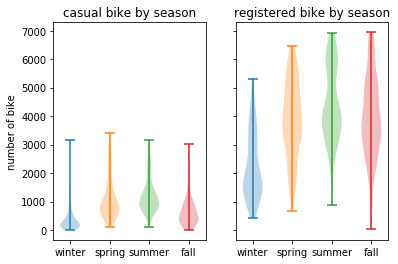

In [18]:

cur_x_pos = 0
#make a box plot and violinplot by for loop/ groupby season.
fig, ax = plt.subplots(1,2 , sharex=True,sharey=True)
for cur_position,cur_df in bikes_by_day.groupby('season'):
    violin_output = ax[0].violinplot(cur_df['casual'], positions=[cur_x_pos])
    violin_output2 = ax[1].violinplot(cur_df['registered'], positions=[cur_x_pos])
    cur_x_pos+=1
    
#set plots' label and name
ax[0].set_xticklabels(['','winter', 'spring', 'summer', 'fall'])
ax[0].set_ylabel("number of bike")
ax[0].set_title('casual bike by season')
ax[1].set_title('registered bike by season')


<HR>
Your answer here
<HR>
It has slight linear relationship.

winter is worst, and getting better to summer, and fall time is going down again.

But, besides winter, each seasons look like almost similar

And it seems like registered users are more sensitive than casual in terms of season.

#### 2.3 What percentage of rentals are made by casual riders or registered riders ...

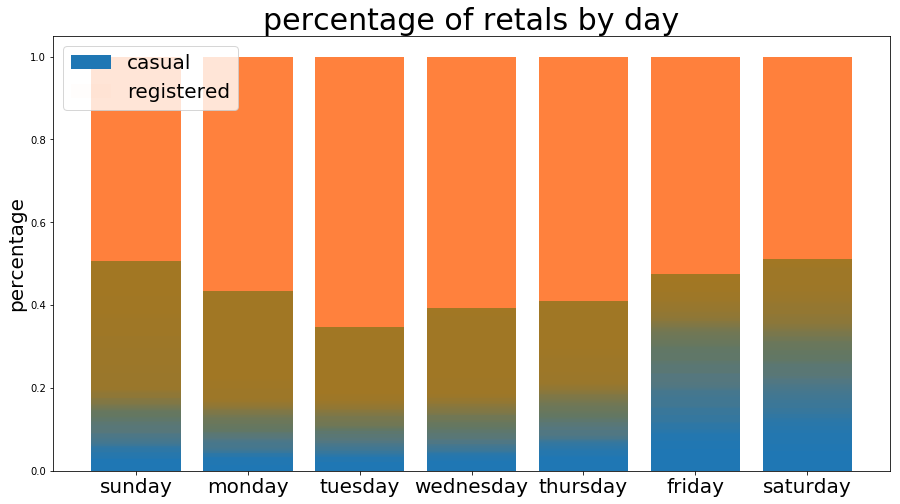

In [19]:
# your code here
percentage_casual = bikes_by_day.casual / bikes_by_day.counts
percentage_registered = bikes_by_day.registered / bikes_by_day.counts
#make stacked percentage plot.
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.bar(bikes_by_day.weekday,percentage_casual, label ='casual')
ax.bar(bikes_by_day.weekday,percentage_registered ,bottom=percentage_casual, alpha=0.01 , label='registered')
#bottom = percentage of causal, so it is able to make stacked percentage bar.

day=['','sunday','monday','tuesday','wednesday','thursday','friday','saturday']
ax.set_title("percentage of retals by day" , fontsize=30)
ax.set_xticklabels(day,fontsize=20)
ax.set_ylabel("percentage",fontsize=20)
ax.legend(fontsize=20)

<HR>
Your answer here
<HR>

As you can see, it is stacked percentage of caual vs registered rentals.
In the weekday, it tends to has less registered users. 
Personally, it is because in weekday, people only use that for commuting.


#### 2.4 How is the distribution of total number of bike rentals different ...

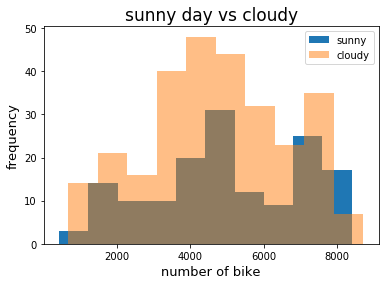

In [21]:
# your code here
#make a plot
fig, ax = plt.subplots(1,1) 
#weather definition
weather_name = ["clear","cloudy"]
clear = bikes_by_day.weather == 1 # because weather 1 is sunny
cloudy = bikes_by_day.weather ==2 # 2 = light cloudy, i do not include 3,4 weather.
# if including 3,4 (extreme weather), just put >= 2. 

#make histograme by conditional data frame.
#i do not use groupby to make like this plot.
ax.hist(bikes_by_day[clear]['counts'], label = "sunny" )
ax.hist(bikes_by_day[cloudy]['counts'], alpha=0.5, label = "cloudy")
ax.set_ylabel("frequency", fontsize=13)
ax.set_xlabel("number of bike", fontsize=13)
ax.set_title("sunny day vs cloudy" , fontsize=17)
ax.legend()



<HR>
Your answer here
<HR>
It is pretty weird, because sunny day is less than cloudy day.

This data is little bit biased by np.max which we did QW2.1

So data is aggregated by maximum weather at each day (worst weather at one day)

Intuitively, hour of cloudy weather is in every single day.

That is one of the reason that cloudy day's frequency is more than sunny day in the above.



#### 2.5 Visualize how the total number of rides per day ...

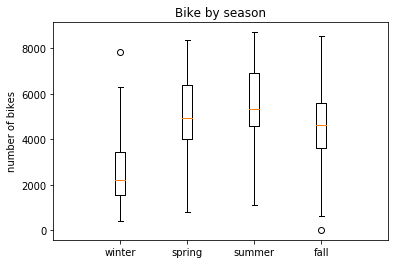

In [22]:
# your code here
cur_x_pos = 0
#make a box plot and violinplot by for loop/ groupby season.
for cur_position,cur_df in bikes_by_day.groupby('season'):
    box=plt.boxplot(cur_df['counts'], positions=[cur_x_pos])
    cur_x_pos+=1
    
    # get the name of each position and set the x ticks
plt.xticks(np.arange(0, 4, step=1), ('winter', 'spring', 'summer', 'fall'))
plt.xlim(-1,4) #make limit to look nice.
# fill in the remaining labels
plt.ylabel("number of bikes")
plt.title("Bike by season")
plt.show()

In [23]:
#outlier investgate
filter_winter = bikes_by_day['season'] == 1   # 1 is winter's season value
filter_winter2= bikes_by_day['counts'] >= 6500 # about more than 6000 is outlier; in the boxplot

filter_fall = bikes_by_day['season'] == 4 # 4 is fall's season value
filter_fall2 = bikes_by_day['counts'] <= 400 #approximately less than 500

#make a logic
outliercheck = np.logical_and(filter_winter,filter_winter2)
outliercheck2 = np.logical_and(filter_fall,filter_fall2)

#find location with the logic
bikes_by_day.loc[outliercheck,:]
bikes_by_day.loc[outliercheck2,:]

#make dataframe to look nice
outlierframe = pd.concat([bikes_by_day.loc[outliercheck,:],bikes_by_day.loc[outliercheck2,:]])
outlierframe

,season,weekday,weather,temp,atemp,hum,windspeed,casual,registered,counts,dteday
dteday,,,,,,,,,,,
2012-03-17,1,5,2,0.514167,0.505046,0.755833,0.110704,3155,4681,7836,2012-03-17
2012-10-29,4,0,3,0.440000,0.439400,0.880000,0.358200,2,20,22,2012-10-29


<HR>
Your answer here
<HR>
Yes, they have about 2 outliers.

one is from winter section, which is more than 6500; following boxplot rule of outliers.

It was saturday of March.
According to News calandar,

"Bolton Wanderer footballer Fabrice Muamba collapses and is rushed to hospital during a live football match against Tottenham Hotspur"

"Wales defeat France to record their eleventh Grand Slam in the Six Nations Championship"

and.. Former President Obama went to Washington D.C's local pub at that day.



The other is 2012-10-29, fall, which total riders were less than 500.

It had an accident.

"Hurricane Sandy makes landfall in New Jersey resulting in 110 deaths and $50 billion in damage and forces the New York stock exchange to close"


<div class='exercise'> <b> Question 3: Prepare the data for Regression </b> </div>

**3.1** Visualize and describe inter-dependencies among the following variables: `weekday`, `season`, `month`,`weather`, `temp`, `atemp`, `hum`, `windspeed`, `casual`,`registered`, `counts`. Note and comment on any strongly related variables.

**3.2** Convert the categorical attributes into multiple binary attributes using **one-hot encoding**. 


**3.3** Split the initial `bikes_df` dataset (with hourly data about rentals) into train and test sets. Do this in a 'stratified' fashion, ensuring that all months are equally represented in each set. Explain your choice for a splitting algorithm. We ask you to create your train and test sets, but for consistency and easy checking we ask that, for the rest of this problem set, you use the train and test set provided in the question below.

**3.4** Read `data/BSS_train.csv` and `data/BSS_test.csv` into dataframes `BSS_train` and `BSS_test`, respectively. After checking your train and test datasets for accuracy, remove the `dteday` column from both train and test dataset. We do not need it, and its format cannot be used for analysis. Also, remove any predictors that would make predicting the `count` trivial.

**3.5** Calculate the **Pearson correlation** coefficients between all the features. Visualize the matrix using a heatmap. Which predictors have a positive correlation with the number of bike rentals? For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Identify pairs of predictors with collinearity >0.7.

#### Hints: 
- You may use the `np.corrcoef` function to compute the correlation matrix for a data set (do not forget to transpose the data matrix). You may use `plt.pcolor` function to visualize the correlation matrix.



#### Answers

#### 3.1 Visualize and describe inter-dependencies  ... 

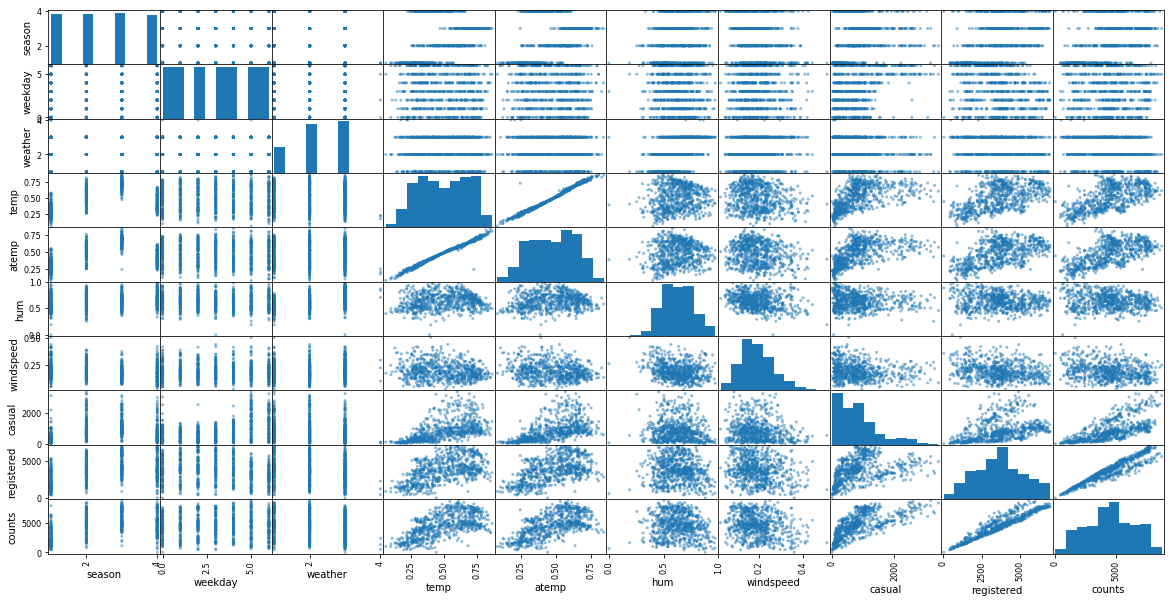

In [24]:
# your code here
scatter_matrix(bikes_by_day, figsize=(20,10));

<HR>
Your answer here
    <HR>
    
We can see about 4 scatter plot has strong linear relationship.
First 2 plots are between temp vs atemp. 
It just makes sense. Temperature is inargualby related to apparent temperature.

Second 2 are scatter between registered and counts.
They also have to be similar. 
It is about number of bikes, so as registered users group grow, of course
total counts(casual user + registered user) are going to go up!

#### 3.2 Convert the categorical attributes  ....

In [25]:
# your code here
# i would use get_dummies to split values which has categorical binary.
designed_bike = pd.get_dummies(bikes_by_day, columns=['season', 'weekday', 'weather'], drop_first=True)
designed_bike.head()

,temp,atemp,hum,windspeed,casual,registered,counts,dteday,season_2,season_3,season_4,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_2,weather_3,weather_4
dteday,,,,,,,,,,,,,,,,,,,,
2011-01-01,0.344167,0.363625,0.805833,0.160446,331,654,985,2011-01-01,0,0,0,0,0,0,0,1,0,0,1,0
2011-01-02,0.363478,0.353739,0.696087,0.248539,131,670,801,2011-01-02,0,0,0,0,0,0,0,0,1,0,1,0
2011-01-03,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011-01-03,0,0,0,0,0,0,0,0,0,0,0,0
2011-01-04,0.200000,0.212122,0.590435,0.160296,108,1454,1562,2011-01-04,0,0,0,1,0,0,0,0,0,1,0,0
2011-01-05,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2011-01-05,0,0,0,0,1,0,0,0,0,0,0,0


<HR>
Your answer here
<HR>

I just get dummies to make sort of 'hot encoding'

So the categorical predictors are now seperated to binary variables.

#### 3.3 Split the initial bikes_df dataset...

In [26]:
# your code here

#I chose 8:2 train : test data set which is typical split portion. 
#And stratified the 'month' data series to make equally distributed.
train_data, test_data = train_test_split(bikes_df, test_size = 0.2, stratify=bikes_df['month'])
train_data.head()

,dteday,season,hour,holiday,weekday,workingday,weather,temp,atemp,hum,windspeed,casual,registered,month,year,counts
4819,2011-07-24,3,17,0,0,0,1,0.90,0.8333,0.39,0.1045,75,174,7,0,249
8420,2011-12-22,1,12,0,4,1,2,0.48,0.4697,0.55,0.0000,22,180,12,0,202
9631,2012-02-11,1,6,0,6,0,3,0.22,0.2273,0.93,0.1343,1,8,2,1,9
7479,2011-11-13,4,6,0,0,0,1,0.34,0.3333,0.66,0.1343,5,18,11,0,23
7654,2011-11-20,4,13,0,0,0,2,0.54,0.5152,0.60,0.1940,84,285,11,0,369


#### 3.4  Read `data/BSS_train.csv` and `data/BSS_test.csv` into ...

In [27]:
# your code here

BSS_train = pd.read_csv('data/BSS_train.csv')
BSS_test = pd.read_csv('data/BSS_test.csv ')


BSS_train_design = BSS_train.drop(columns = ['dteday', 'casual','registered','Unnamed: 0'])
BSS_test_design = BSS_test.drop(columns = ['dteday', 'casual','registered','Unnamed: 0'])
#I drop also casual, registered column because it has high relationship with counts.


#check it
print(BSS_train_design.dtypes)
BSS_train.head()

hour            int64
holiday         int64
year            int64
workingday      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
counts          int64
spring          int64
summer          int64
fall            int64
Feb             int64
Mar             int64
Apr             int64
May             int64
Jun             int64
Jul             int64
Aug             int64
Sept            int64
Oct             int64
Nov             int64
Dec             int64
Mon             int64
Tue             int64
Wed             int64
Thu             int64
Fri             int64
Sat             int64
Cloudy          int64
Snow            int64
Storm           int64
dtype: object


,Unnamed: 0,dteday,hour,holiday,year,workingday,temp,atemp,hum,windspeed,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
0,0,2011-01-01,0,0,0,0,0.24,0.2879,0.81,0.0,...,0,0,0,0,0,0,1,0,0,0
1,1,2011-01-01,1,0,0,0,0.22,0.2727,0.80,0.0,...,0,0,0,0,0,0,1,0,0,0
2,2,2011-01-01,2,0,0,0,0.22,0.2727,0.80,0.0,...,0,0,0,0,0,0,1,0,0,0
3,3,2011-01-01,3,0,0,0,0.24,0.2879,0.75,0.0,...,0,0,0,0,0,0,1,0,0,0
4,4,2011-01-01,4,0,0,0,0.24,0.2879,0.75,0.0,...,0,0,0,0,0,0,1,0,0,0


Answer

I removed casual, registered variables which have very high collinearity with each other,

also with the 'counts'

#### 3.5 Calculate the **Pearson correla**3.5** Calculate the **Pearson correlation** coefficients between all the features. Visualize the matrix using a heatmap. Which predictors have a positive correlation with the number of bike rentals? For categorical attributes, you should use each binary predictor resulting from one-hot encoding to compute their correlations.  Identify pairs of predictors with collinearity >0.7.tion** ....

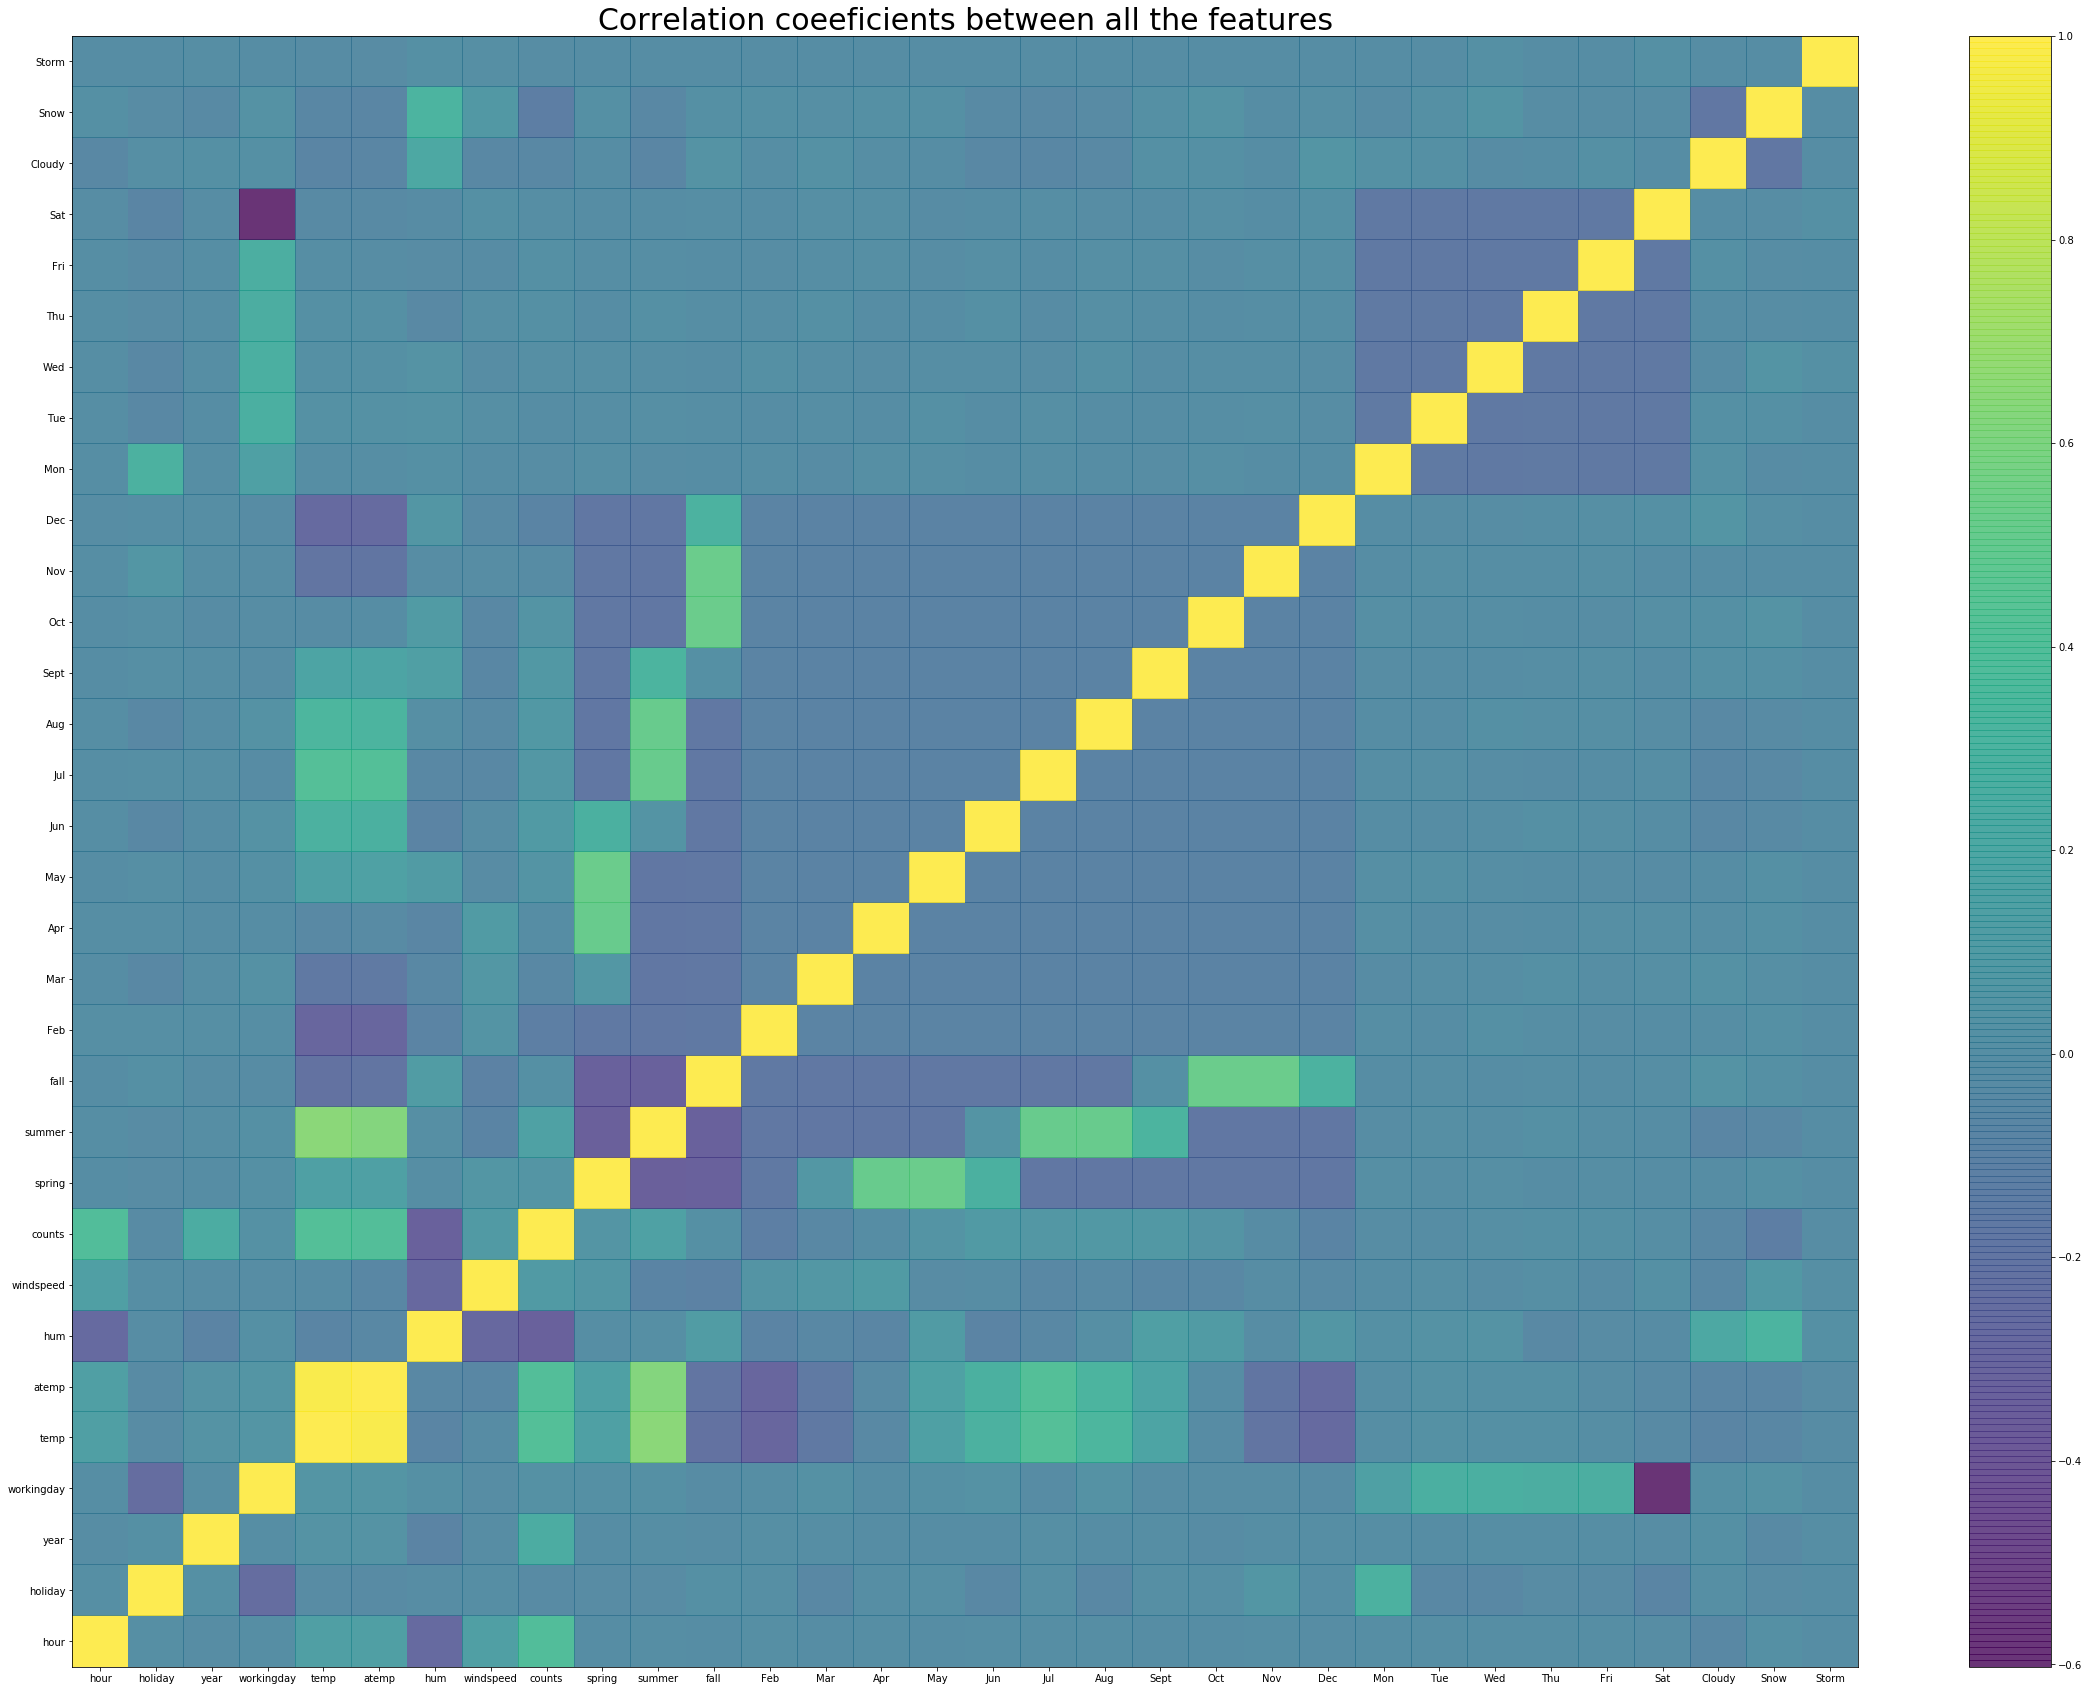

In [28]:
# your code here
correlation = np.corrcoef(BSS_train_design.T) #transpose
fig, ax =plt.subplots(1,1, figsize = (40,30))
#make a heatmap.
heat = ax.pcolor(correlation,  alpha=0.8)
ax.set_xticks(np.arange(len(list(BSS_train_design)))+0.5)
ax.set_yticks(np.arange(len(list(BSS_train_design)))+0.5)
ax.set_xticklabels(list(BSS_train_design))
ax.set_yticklabels(list(BSS_train_design))
ax.set_title("Correlation coeeficients between all the features", fontsize=30)
plt.colorbar(heat)


In [29]:
#make a dataframe of correlation to find data easily.

cor_df = pd.DataFrame(correlation)
cor_df.index = list(BSS_train_design)
cor_df.columns = list(BSS_train_design)

condition = cor_df.counts >0
condition2 = cor_df > 0.7
condition22 = 0.99999 > cor_df   # because it has to be not 1 ; equal., 
#if i put 1, it includes 0.99999999999999999999999 which is 1.

checker = np.logical_and(condition2,condition22)


print(cor_df.counts[condition])# positive values in 'counts'
print('\n')
print('')
cor_df[checker] # show more than 0.7   /  NaN is not accepted.
#It is messy but i just show that the others are False
#Only atemp and temp's correlation is > 0.7.


hour          0.394167
year          0.243886
workingday    0.029534
temp          0.406155
atemp         0.401119
windspeed     0.093981
counts        1.000000
spring        0.058418
summer        0.159319
fall          0.022531
May           0.050471
Jun           0.094448
Jul           0.073333
Aug           0.085847
Sept          0.080225
Oct           0.046657
Wed           0.006535
Thu           0.018731
Fri           0.015080
Sat           0.000878
Name: counts, dtype: float64





,hour,holiday,year,workingday,temp,atemp,hum,windspeed,counts,spring,...,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Cloudy,Snow,Storm
hour,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workingday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,NaN,NaN,NaN,NaN,NaN,0.987408,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
atemp,NaN,NaN,NaN,NaN,0.987408,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
windspeed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
counts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
spring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<HR>
Your answer here
<HR>
Positive values in 'counts' row are 

'hour', 'year', 'workingday', 'temp', 'atemp', 'windspeed', 'counts','spring', 'summer', 'fall', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct','Wed', 'Thu', 'Fri', 'Sat'.

But usually their score is not that high.

Hour, year, atemp,temp are high score in the group. 

Atemp, temp are about temperature, we could guess why.

And hour, i think this predictor is from 0 (midnight) to 24. So usually 8am (morning rushour)

and 20 (evening) has significantly high response. So it could seem like has some relationship.

Year is probably because the total user number is growing ,as time goes.

And  pairs of predictors with collinearity >0.7 are only temp, atemp which we explored before.


<div class='exercise'> <b> Question 4: Multiple Linear Regression </b> </div>

**4.1** Use statsmodels to fit a multiple linear regression model to the training set using all the predictors (no interactions or polynomial terms), and report its $R^2$ score on the train and test sets.


**4.2** Find out which of estimated coefficients are statistically significant at a significance level of 5% (p-value < 0.05). Comment on the results.


**4.3** Make a plot of residuals of the fitted model ${e} = y - \hat{y}$ as a function of the predicted value $\hat{y}$. Note that this is slightly different from the residual plot for simple linear regression. Draw a horizontal line denoting the zero residual value on the Y-axis. Does the plot reveal a non-linear relationship between the predictors and response? What does the plot convey about the variance of the error terms? 

### Answers
#### 4.1 Use statsmodels to fit a ... 


In [30]:
# your code here
y_train = BSS_train_design.counts
#make y_train set. which is 'counts
statsmodels = OLS(y_train, BSS_train_design.drop('counts',axis=1)).fit()
#delete response value 'counts' 


y_test = BSS_test_design.counts
statsmodels_test = OLS(y_test, BSS_test_design.drop('counts',axis=1)).fit()
print("train set R^2")
print(statsmodels.rsquared)
print("test set R^2")
print(statsmodels_test.rsquared)

train set R^2
0.71568619765
test set R^2
0.721388498254


<HR>
Your answer here
<HR>
Train set's R squared score is about 0.715

And test set's is 0.721 slightly better than train set.

#### 4.2 Find out which of estimated coefficients ...

In [31]:
# your code here
pvalues = statsmodels.pvalues         
#find pvalues
print(pvalues.loc[pvalues<0.05].index.values)
#find pvalues' condition. <0.05. and get values


#do same thing in test set
pvalues_test = statsmodels_test.pvalues
print(pvalues_test.loc[pvalues<0.05].index.values)

['hour' 'holiday' 'year' 'workingday' 'temp' 'hum' 'spring' 'summer' 'fall'
 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Nov' 'Tue' 'Sat' 'Cloudy'
 'Snow']
['hour' 'holiday' 'year' 'workingday' 'temp' 'hum' 'spring' 'summer' 'fall'
 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Nov' 'Tue' 'Sat' 'Cloudy'
 'Snow']


<HR>
Your answer here<BR>
<HR>

Coefficients which pvalues are significant when 0.05 are 

['hour' 'holiday' 'year' 'workingday' 'temp' 'hum' 'spring' 'summer' 'fall'
 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Jul' 'Aug' 'Nov' 'Tue' 'Sat' 'Cloudy'
 'Snow']
 
test model, and train model are same.

That means we are more than 95 % confidence our estimates are in True values.
So our guess values of the above list, are statistically significant in 0.05 pvalue level.

#### 4.3 Make a plot of residuals of the fitted ...

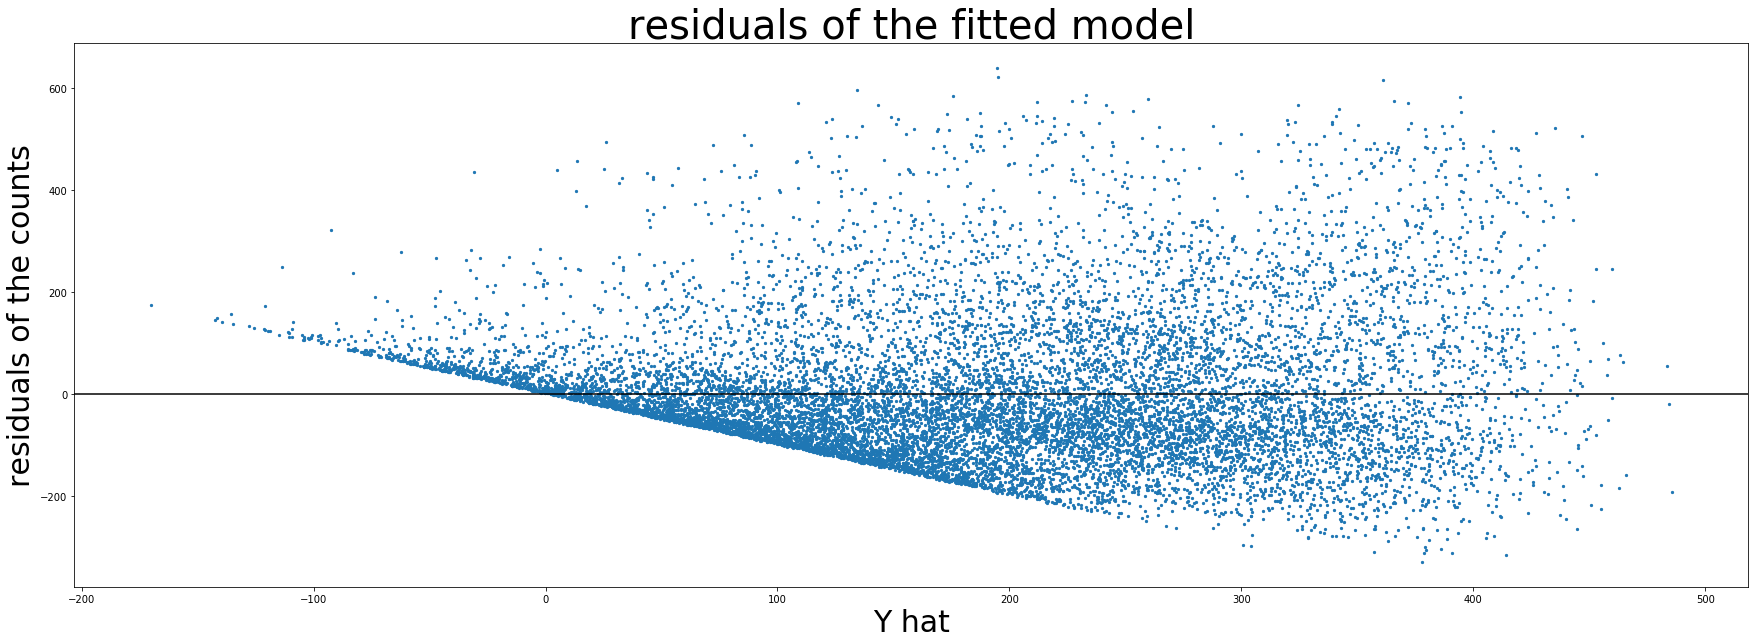

In [32]:
# your code here

prediction = statsmodels.predict(BSS_train_design.drop('counts',axis=1)) #Y hat
residual = y_train - prediction #residual Y - Yhat

fig, ax =plt.subplots(1,1, figsize=(30,10))
ax.scatter(prediction,residual, s=5) #scatter X = number of trial, Y = residual
ax.axhline(0, color='k') #make horizontal
ax.set_title("residuals of the fitted model", fontsize=40)
ax.set_ylabel("residuals of the counts",fontsize=30)
ax.set_xlabel("Y hat",fontsize=30)

it has some high residuals. But many of residuals are in 0 line, although it is not that linear,

We cannot say it is 'non' linear I think. Because it has a negative linear relation.

I would say 'not good' linear relationship, so we have to change a regression model. 

<div class='exercise'> <b>Question 5: Subset Selection </b> </div>

**5.1** Implement forward step-wise  selection to select a minimal subset of predictors that are related to the response variable: 

We require that you implement the method **from scratch**. You may use the Bayesian Information Criterion (BIC) to choose the subset size in each method. 

**5.2** Do these methods eliminate one or more of the colinear predictors (if any) identified in Question 3.5?  If so, which ones. Briefly explain (3 or fewer sentences) why you think this may be the case.

**5.3** Fit the linear regression model using the identified subset of predictors to the training set. How do the test $R^2$ scores for the fitted models compare with the model fitted in Question 4 using all predictors?

### Answers

#### 5.1  Implement forward step-wise ....

In [34]:
# your code here
X_train = BSS_train_design.drop('counts',axis=1)
#y_train is already defined.

#make get bic function.
def get_bic(X_train, y_train):
    model = sm.OLS(y_train, X_train).fit()
    return model.bic
#define All predictor in X_train.
All_predictor = X_train.columns.values

#make function by using recursive.            ps. it was hard :(

def recursive(X_train,y_train): #Ksubset = how many predictor you want. defalut = one.
    forward = [] #make blank list to use recursive
    bestK = []   #again
    New_list=All_predictor  #I will use this list as a list that subtract by my new list.
    #basically this is All_predictor - the list i want.
    base = get_bic(X_train['atemp'], y_train)  # base will be previous bic to compare with new one.
    bic = [0] # defalut 0. to compare at first time
    #use while function to recursive
    while base > bic[-1] :  # until how many predictor i want.
        #use for loop to check which predictor is lowest bic
        for i in New_list:  # in my list ; now it's full list, because not subtract yet.
            tempbestK = [i]     #this is i in my list
            tempbestK = tempbestK + bestK  # i will plus the value that i will chose.
            # so it will be   [i , bestK (the lowest bic value)]
            forward.append(get_bic(X_train[tempbestK] , y_train))
            #append in blank list to compare bic score
            
        index = forward.index(np.min(forward)) #find the lowest predictor's index
        bestK.append(New_list[index])  #and append in my list (bestK)
        New_list = list(set(New_list) - set(bestK))   #subtract bestK and New list without best.
        bic.append(np.min(forward))
        if len(bic) > 2:
            base = bic[-2]      #because before len(bic) > 2, we cannot compare new bic and previous
        print("bic score at this level : {0} ".format(np.min(forward)))
        #print bic score at this level.
        
        #at this level's best K
        print(bestK)
        forward = []
    else:
        return bestK

recursive(X_train , y_train)


bic score at this level : 181370.05948206075 
['temp']
bic score at this level : 179717.78889599905 
['temp', 'hour']
bic score at this level : 178507.4313182908 
['temp', 'hour', 'hum']
bic score at this level : 177406.0933170423 
['temp', 'hour', 'hum', 'year']
bic score at this level : 177013.4289194019 
['temp', 'hour', 'hum', 'year', 'fall']
bic score at this level : 176890.1929321 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul']
bic score at this level : 176859.9630762387 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow']
bic score at this level : 176837.18306968478 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow', 'Aug']
bic score at this level : 176799.12697903012 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow', 'Aug', 'Jun']
bic score at this level : 176786.91669396736 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow', 'Aug', 'Jun', 'holiday']
bic score at this level : 176786.06397410823 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow', 'Aug', 'Jun'

['temp',
 'hour',
 'hum',
 'year',
 'fall',
 'Jul',
 'Snow',
 'Aug',
 'Jun',
 'holiday',
 'spring',
 'summer']

<HR>
Your answer here
<HR>

I will choose ['temp', 'hour', 'hum', 'year', 'fall', 'Jul'].

At this level's bic score is 176890.

And after this, the score is not changed as much as before.

So this 5 is the most effective predictors in the list.


or if choose the smallest BIC, 

['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow', 'Aug', 'Jun', 'holiday', 'spring']

11.

#### 5.2 Do these methods eliminate ...

<HR>
Your answer here
<HR>

It would eliminate a lot of predictor that we found in 3.5

(i am talking about the positive predictor in 3.5)

Because at the 3.5, they are just positive predictors, not effective predictors.

Almost every predictor affects the result, but i will remove not effective ones.

#### 5.3 In each case, fit linear regression  ...

In [37]:
# your code here
bestK = recursive(X_train , y_train)
new_model = OLS(y_train, X_train[bestK]).fit()
new_model.rsquared


bic score at this level : 181370.05948206075 
['temp']
bic score at this level : 179717.78889599905 
['temp', 'hour']
bic score at this level : 178507.4313182908 
['temp', 'hour', 'hum']
bic score at this level : 177406.0933170423 
['temp', 'hour', 'hum', 'year']
bic score at this level : 177013.4289194019 
['temp', 'hour', 'hum', 'year', 'fall']
bic score at this level : 176890.1929321 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul']
bic score at this level : 176859.9630762387 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow']
bic score at this level : 176837.18306968478 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow', 'Aug']
bic score at this level : 176799.12697903012 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow', 'Aug', 'Jun']
bic score at this level : 176786.91669396736 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow', 'Aug', 'Jun', 'holiday']
bic score at this level : 176786.06397410823 
['temp', 'hour', 'hum', 'year', 'fall', 'Jul', 'Snow', 'Aug', 'Jun'

0.71459836398716625

<HR>
Your answer here
<HR>
Rsquare is of course smaller than the model has every predictor,

however, it is relatively high. We choose only 11 predictor!

Aboue 30 predictor with 0.715 R squared before. vs. Now 11 predictor with 0.714 R squared

<div class='exercise'> <b> Question 6: Polynomial Regression </b> </div> 

We will now try to improve the performance of the regression model by including higher-order polynomial terms. 

**6.1** For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a polynomial regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in the previous question? Using a $t$-tests, find out which of the estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

In [43]:
# your code here
from sklearn.linear_model import LinearRegression #import LinearRegression model.

#make for loop to put all variables
for i in ['temp','atemp','hum','windspeed']:
    X_train[i] = X_train[i]
    X_train[i+"squared"] = X_train[i]**2
    X_train[i+"triple"] = X_train[i] **3
    X_train[i+"quadrupled"] = X_train[i] **4
    

#I do not know that this question is including interaction term, so just make it.


poly_model = OLS(y_train, X_train).fit()
poly_model.summary()
polypvalues = poly_model.pvalues

print(polypvalues.loc[polypvalues<0.05].index.values)


['hour' 'holiday' 'year' 'workingday' 'spring' 'summer' 'fall' 'Apr' 'May'
 'Jun' 'Jul' 'Aug' 'Tue' 'Sat' 'Cloudy' 'Snow' 'tempsquared' 'temptriple'
 'tempquadrupled' 'windspeedsquared' 'windspeedtriple'
 'windspeedquadrupled']


<HR>
Your answer here
<HR>


temp          float64

atemp         float64

hum           float64

windspeed     float64

this is all of the continuous variables, unlike discrete variables which are int.

but we do not know whether interaction term is including or not.

so i made just ugly X_new features to cacultate without interaction term

 ['hour' 'holiday' 'year' 'workingday' 'spring' 'summer' 'fall' 'Apr' 'May'
 'Jun' 'Jul' 'Aug' 'Tue' 'Sat' 'Cloudy' 'Snow' 'tempsquared' 'temptriple'
 'tempquadrupled' 'windspeedsquared' 'windspeedtriple'
 'windspeedquadrupled']
 
 That values are significant when p-values >0.05




#  Written Report to the Administrators
<br>

<div class='exercise'> <b> Question 7 </b> </div>

Write a short summary report, intended for the administrators of the company, to address two major points (can be written as two large paragraphs):

1. How to predict ridership well (which variables are important, when is ridership highest/lowest, etc.).

2. Suggestions on how to increase the system revenue (what additional services to provide, when to give discounts, etc.).
 
Include your report below. The report should not be longer than 300 words and should include a maximum of 3 figures. 

### Answers
#### 7
<HR>
Your report here
<HR>

1. As we researched about which variables are important, we can choose the top 3 variables

"Temperature, hour of day, humidity" these 3 varibales are that we have to use for prediction ridership.

Tmepreature literally makes sense, when tempreature is too low, nobody are willing to ride a bike.

So higher tempreature, more total riders are coming.

And we have when was the highest ridership, and the lowest.


In [40]:
outlierframe

,season,weekday,weather,temp,atemp,hum,windspeed,casual,registered,counts,dteday
dteday,,,,,,,,,,,
2012-03-17,1,5,2,0.514167,0.505046,0.755833,0.110704,3155,4681,7836,2012-03-17
2012-10-29,4,0,3,0.440000,0.439400,0.880000,0.358200,2,20,22,2012-10-29


2012-03-17 has almost 8000 riders in that day.

It was the day that Former President Obama went to local pub. 

probably it makes some congestion.

Lowest day was 2012-10-29. windspeed was pretty high, and it had hurricane in the east coast.


2.The simple way to increase a revenue is considering the weather!

the below graph says that in bad weather, losing significantly users. 

I suggest the crazy idea likes this.

" If you can ride a bike under the hurricane, we will give you present!"

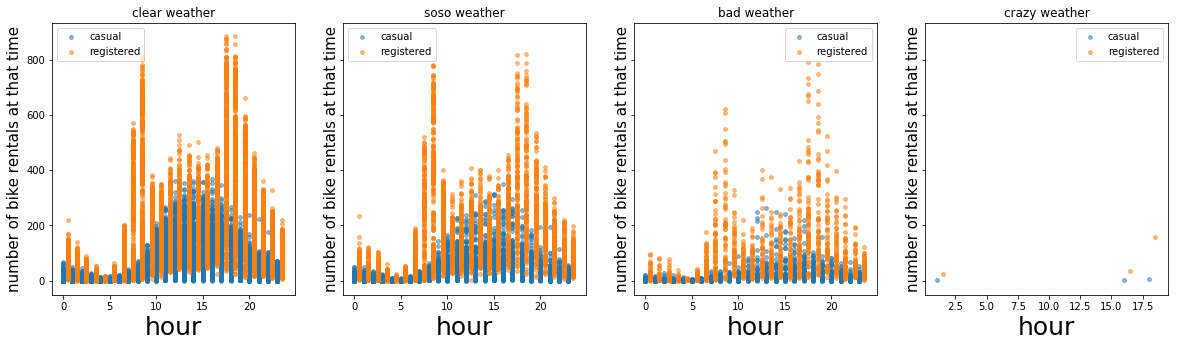

In [41]:
# your code here

#one dot = each day's specific time
fig, ax = plt.subplots(1,4, figsize=(20,5), sharey=True) #make 2 plot to compare
#weather definition
weather_name = ["clear","soso","bad", "crazy"]
for i in range(4):
    weather = bikes_df['weather'] == i+1 #condition weather
    ax[i].scatter(bikes_df[weather]['hour'],bikes_df[weather]['casual'], s=15, alpha=0.5)
    ax[i].scatter(bikes_df[weather]['hour']+0.5,bikes_df[weather]['registered'],alpha =0.5, s=15)
    ax[i].set_title("{0} weather".format(weather_name[i], fontsize =40))
    ax[i].set_ylabel("number of bike rentals at that time", fontsize=15)
    ax[i].set_xlabel("hour", fontsize=25)
    ax[i].legend()
